## Reload configuration
First reload everything as per earlier.

In [5]:
%matplotlib inline
import matplotlib.pyplot as pl
import numpy
import sys
import os
sys.path.append(os.getcwd())
import regressiondemo as rd

##############################
#      Customize the demo here
#      =======================
# the "true" function of x with range fixed at [0,10]
def truefunc(x):
    return numpy.sin(x*2.0)*numpy.sqrt(numpy.absolute(x))/3.3

#  when fitting goes wild, need to constrain what y's are plotted
#  must be compatible with "true" function
ydisplaymin = -1.8
ydisplaymax = 1.8

#  noise level as std.dev
rd.setSigma(0.2)
#  don't make points more than 100 as demo is O(points^3)
points = 30
##############################

# xts and yts store the "true" function for the purposes of plotting
# these have to be high frequency to make the resultant plot look
# like a smooth curve
xts = rd.makeX(200,uniform=True)
yts = truefunc(xts)

#  build a set of polynomial orders to use to fit
orders = rd.makeOrders(points)

# make canvas size a bit bigger (in inches)
bigcanvas = [8,6]

Linear Regression with Smoothed Legendre Polynomials
============
Now to complete this series of illustrations, lets make a better effort of linear regression.  Simple linear regression with powers is not very smart and self-respecting statisticians would only use it in two contexts:
*  they have loads of data so the statistical fitting methods can be naive, or
*  they need a quick and dirty solution, for instance implemented on limited hardware.

One can do a much better.  There are many other methods one can use, and generally one needs a [non-parametric statistical](http://en.wikipedia.org/wiki/Nonparametric_statistics) method or a Bayesian non-parametric method.  These aren't constrained to a particular order of polynomial and attempt to fit complexity as needed. A popular technique here is to use [Gaussian processes](http://en.wikipedia.org/wiki/Gaussian_processes), which are a Bayesian non-parametric method.  

We'll instead use a method using Smoothed Legendre Polynomials that is half-way between a Gaussian process and standard linear regression.  The details are not important for this demonstration but some details can be found in the other notebook "RegressionLegendreDetail.ipynb".  Legendre polynomial smoothing is designed for the case when our functions are "smooth" and tend to have less curvature on average.  


Step 2.1:  Different orders of smoothed Legendre polynomials
----------
We'll start by fitting different orders of these just as we did above with the "simple polynomials on different data" plot previously.

Fitting polynomials of orders =  [3, 6, 12, 25]


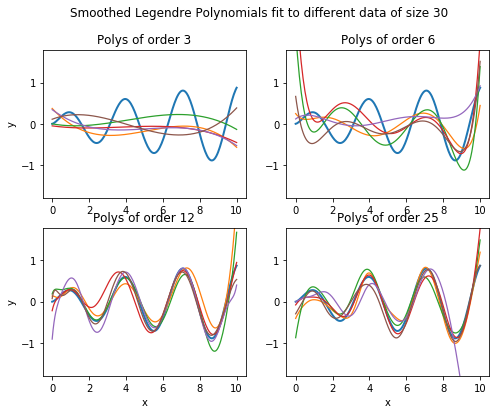

In [6]:
##############################
#      Customize the plot here
#      =======================
#      grab last for orders to plot a 2X2
fourorders = orders[-4:]
#  fourorders = [3,6,10,20]
points = 30
#  data sets per plot to show
setcount = 5
##############################

print ('Fitting polynomials of orders = ', fourorders)

# make canvas size a bit bigger (in inches)
pl.figure(figsize=bigcanvas)
pl.suptitle( 'Smoothed Legendre Polynomials fit to different data of size '+str(points))
sp = 1;
for order in fourorders:
    pl.subplot(2,2,sp)
    sp += 1
    #  plot the truth
    pl.plot(xts, yts, linewidth=2) # default is green line? 
    #  be careful when we show the x/y axes
    if sp>3:
        pl.xlabel('x')
    if sp%2==0:
        pl.ylabel('y')
    legpoly = rd.LegPoly(order)    
    for s in range(setcount):
        # generate another sample
        xb = rd.makeX(points)
        yb = rd.addNoise(truefunc(xb))
        # fit the polynomial
        legpoly.fit(xb, yb) 
        #  build the fitted poly curve 
        ys = legpoly.apply(xts)
        #  plot fitted curve
        pl.plot(xts, ys, linewidth=1.25 ) 
        
    pl.title('Polys of order '+str(order))
    
    #  the y range for the plot has to be altered depending on the data
    pl.ylim(ydisplaymin,ydisplaymax)

Unlike standard linear regression, the fit doesn't start to go wild with higher orders of polynomials.  The fit has been "smoothed" at the higher orders.  So while for the lower orders, things look the same as with standard regression, for higher orders the fit generally keeps improving and the fitted polynomial no longer goes wild.  For standard linear regression we needed to reach a compromise: we want smaller bias but not to much variance.  For the smoothed method, no such compromise is needed. 

Step 2.2:  Comparing regular regression with smoothed regression
--------
Lets look at this closer by doing a head-to-head comparison with the two methods at the higher order.

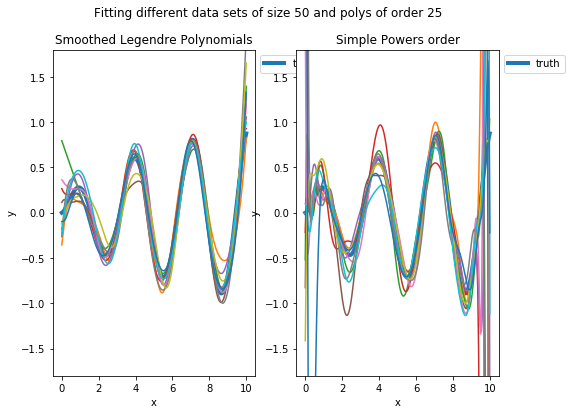

In [7]:
##############################
#      Customize the plot here
#      =======================
#   set poly order (default = last order from array)
order = orders[-1]
#  order = 20
points = 50
##############################

legpoly = rd.LegPoly(order)

pl.figure(figsize=bigcanvas)
sp = 1
pl.suptitle('Fitting different data sets of size '+str(points)+' and polys of order '+str(order))
for useLegendre in [True,False]:
  # plotting stuff:
  #    plot the truth only, 
  #    not data since it varies per plot
  pl.subplot(1,2,sp)
  sp += 1
  pl.plot(xts, yts,label = 'truth', linewidth=4)
  pl.ylabel('y')
  pl.xlabel('x')
  pl.ylim(ydisplaymin,ydisplaymax)
  pl.legend(bbox_to_anchor=(1, 1))
  if useLegendre:
        pl.title("Smoothed Legendre Polynomials")
  else:
        pl.title("Simple Powers order")
  for sample in range(10):
    # generate new data (x,y)
    x = rd.makeX(points)
    y = rd.addNoise(truefunc(x))
    
    # fit a polynomial then build a curve to plot using grid xts
    if useLegendre: 
        # fit the polynomial
        legpoly.fit(x,y)
        #  build the fitted poly curve 
        ys = legpoly.apply(xts)
    else:
        #  build the fitted poly curve 
        ys = rd.linReg(x,y,xts,order)
    
    #  plot fitted curve
    pl.plot(xts, ys)


Compare the fits with the Simple Powers versus the Smoothed Legendre Polynomials. How would you describe the difference?

Step 2.3:  Seeing the fits converge
------------
So lets start with a small data set and gradually increase it, adding more data.  Now run our fitting algorithm on each in turn.  How does the sequence of fits look?

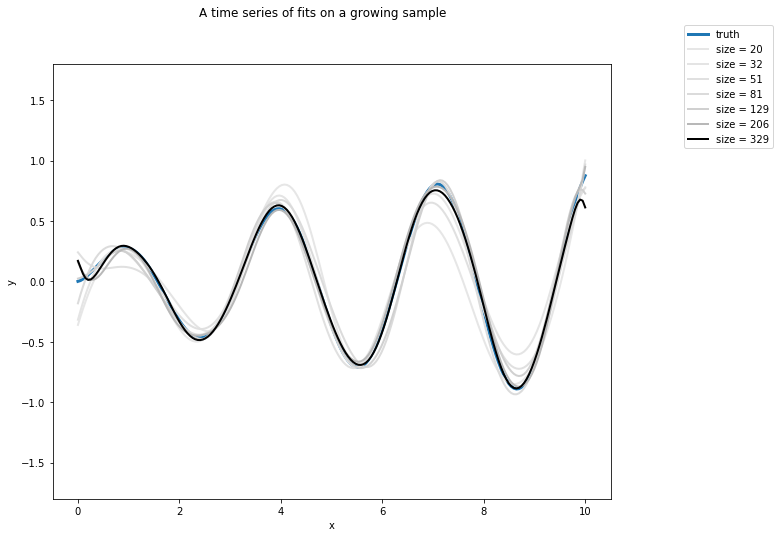

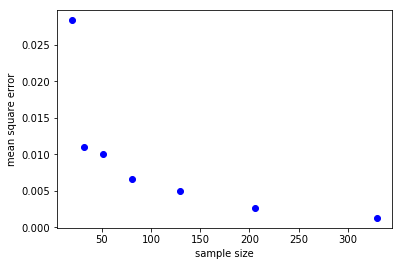

In [8]:
##############################
#      Customize the plot here
#      =======================
#  increase data set by this each time
growth = 0.6
#  bounds on dataset size
maxpoints = 500
startpoints = 20
#############################

# make canvas size a bit bigger (in inches)
pl.figure(figsize=[10,8])

pl.plot(xts, yts,label = 'truth', linewidth=3.0)
#   can be handy to modify the point size for data, 
#   use 2,4,6 depending on data set size
pl.ylabel('y')
pl.xlabel('x')
        
legpoly = rd.LegPoly(order) 

#  generate the starting data set
points = startpoints
x = rd.makeX(points)
y = rd.addNoise(truefunc(x))

#  keep stats about fits
pointSeries = numpy.zeros(0)
mseSeries = numpy.zeros(0)

#  initial trial to find out maximum used points
maxusedpoints = points
while points<maxpoints:
    newpoints = int(points*growth)
    if newpoints<1:
        newpoints = 1
    maxusedpoints = points
    points += newpoints
    
points = startpoints    
while points<maxpoints:
    y = rd.addNoise(truefunc(x))
    # now, subsequently, we sample a new curve
    legpoly.fit(x,y)
    #  build the fitted poly curve 
    ys = legpoly.apply(xts)  
    #   scale points to get a grey code
    ccode = 0.9*numpy.log(1.0 + 100*(maxusedpoints-points)/(maxusedpoints-startpoints))/numpy.log(101.0)
    #  plot fitted curve
    pl.plot(xts, ys,linewidth=2, color=str(ccode),label="size = "+str(points) )  
    #  store results
    pointSeries = numpy.append(pointSeries,points)
    mseSeries = numpy.append(mseSeries,numpy.mean((yts-ys)*(yts-ys)))
    #  increase the data set, bit of a hack
    newpoints = int(points*growth)
    if newpoints<1:
        newpoints = 1
    newx = rd.makeX(newpoints)
    x = numpy.append(x,newx)
    y = numpy.append(y,rd.addNoise(truefunc(newx)))
    points += newpoints
    
#  the y range for the plot has to be altered depending on the data
pl.ylim(ydisplaymin,ydisplaymax)

# move the legend out of the way
# the (1.2, 1.2) starts the legend at the location relative to
# the top right corner
pl.legend(bbox_to_anchor=(1.3, 1.1))
pl.suptitle('A time series of fits on a growing sample')
pl.show()

pl.plot(pointSeries,mseSeries,'bo')
pl.ylabel('mean square error')
pl.xlabel('sample size')

Its instructive to change the number of data points used, from say from 10 upwards and look at the change in variability of the ensemble of functions.  In the first plot, as the fitted curve gets darker, which means it is based on more data, it gets closer and closer to the truth.  In the second plot, the mean squre error of the fitted curve with the truth decreases dramatically with more data.